# New York is Burning

In this notebook we fit different time series models to the `weather_data.csv` data scraped using
[NCEI API](https://www.ncei.noaa.gov/support/access-data-service-api-user-documentation) from a NY
 city weather station.

## Intro
Import initial libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from datetime import datetime

Load the data set

In [2]:
df = pd.read_csv("weather_data.csv")[["DATE", "TMAX", "TMIN"]]
df = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55501 entries, 0 to 55500
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    55501 non-null  object 
 1   TMAX    55494 non-null  float64
 2   TMIN    55494 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.3+ MB


The dataset contains different columns from where we will only use `DATE`, `TMAX` and `TMIN`.
Just a few rows have missing values. Replace them using the previous row.

In [3]:
df["TMAX"].fillna(method="ffill", inplace=True)
df["TMIN"].fillna(method="ffill", inplace=True)

Use the `DATE` column as time reference.

In [4]:
df["DATE"] = df["DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df.index = df["DATE"]
df.drop(columns="DATE", inplace=True)

We will focus on analyzing monthly average temperatures. Calculate the means and
save them in new dataframes.

In [5]:
monthly_df = df.groupby(pd.Grouper(freq="M")).mean()

## Decomposing Seasonally
Seasonal decomposition is a technique used to extract multiple components form a time series:
1. **The Trend**: reflects the long-term progression of the series.
2. **Seasonal**: reflects seasonality of the series.
3. **Residuals**: the noise. It represents the remainder of the time series after the other
components have been removed.

In our case, we implement the additive model for both maximum and minimum temperatures, that is,
at a time t:

Time-Series[t] = Trend[t] + Seasonal[t] + Residual[t].

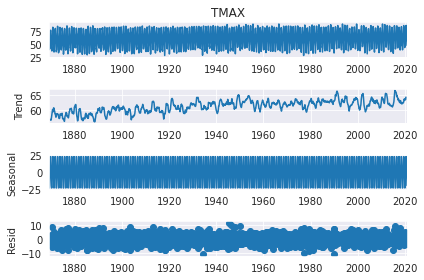

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(monthly_df["TMAX"], model="additive")
result.plot()
plt.show()

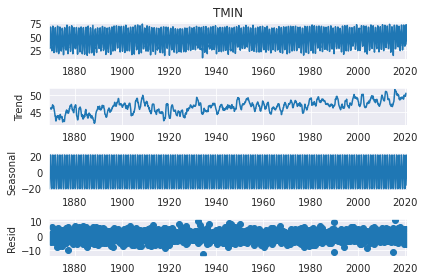

In [7]:
result = seasonal_decompose(monthly_df["TMIN"], model="additive")
result.plot()
plt.show()

**There exists an increasing Trend for both graphs.**

### Lag and Differentiation
To know what has changed over time. One simple technique is to compare time t, with time t-1.
So we define the Lag column, which contains the shifted values in one step. And the Differentiation
column, with the difference between a time and the previous one.

In [8]:
monthly_df["tmax_lag1"] = monthly_df["TMAX"].shift(1)
monthly_df["tmax_diff1"] = monthly_df["TMAX"].diff(periods=1)
monthly_df["tmin_lag1"] = monthly_df["TMIN"].shift(1)
monthly_df["tmin_diff1"] = monthly_df["TMIN"].diff(periods=1)

monthly_df.dropna(inplace=True)

In [9]:
monthly_df[["tmax_lag1", "tmin_lag1", "tmax_diff1", "tmin_diff1"]].head(6)

,tmax_lag1,tmin_lag1,tmax_diff1,tmin_diff1
DATE,,,,
1869-02-28,39.516129,29.677419,0.198157,0.215438
1869-03-31,39.714286,29.892857,2.124424,-0.925115
1869-04-30,41.838710,28.967742,13.727957,15.165591
1869-05-31,55.566667,44.133333,6.594624,7.963441
1869-06-30,62.161290,52.096774,11.605376,12.669892
1869-07-31,73.766667,64.766667,4.007527,3.555914


### Train Test Split
Before training any Machine Learning model, we need to split the data into training and testing
sets.

The first 90% of the data is assigned to the training set, and the last 10% to the testing.

In [10]:
train_size = int(monthly_df.shape[0] * 0.9)
train = monthly_df[:train_size]
test = monthly_df[train_size:]

X_train, y_train = train[["tmax_lag1", "tmin_lag1"]], train[["TMAX", "TMIN"]]
X_test, y_test = test[["tmax_lag1", "tmin_lag1"]], test[["TMAX", "TMIN"]]

## Monthly Analysis

### Base Model
The easiest time series model is to predict the value of the time t+1 as the same as the value of
 time t. (Tomorrow's max temperature would be predicted as the same as today's max temperature,
 and so on

Doing this, we obtain the following mean absolute errors.

In [11]:
predictions = X_test.copy()

In [12]:
from sklearn.metrics import mean_absolute_error
tmax_mae = mean_absolute_error(y_test["TMAX"], predictions["tmax_lag1"])
tmin_mae = mean_absolute_error(y_test["TMIN"], predictions["tmin_lag1"])
print(f"Maximum Temperature Mean Absolute Error: {round(tmax_mae, 2)}")
print(f"Minimum Temperature Mean Absolute Error: {round(tmin_mae, 2)}")

Maximum Temperature Mean Absolute Error: 8.06
Minimum Temperature Mean Absolute Error: 7.56


Graphically, we have:

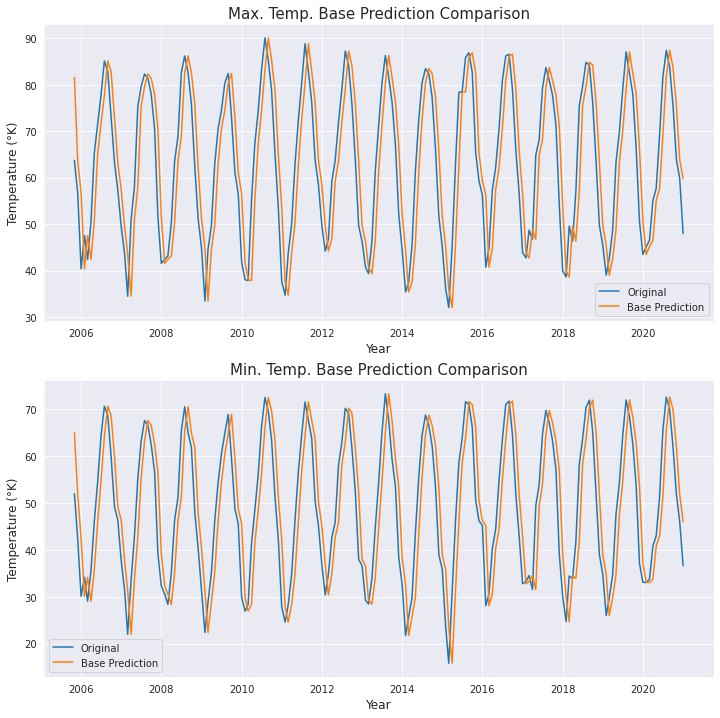

In [13]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))
sns.lineplot(x=y_test.index, y=y_test["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=predictions.index, y=predictions["tmax_lag1"].values,
             label="Base Prediction", ax=axes[0])
axes[0].set_title("Max. Temp. Base Prediction Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=y_test.index, y=y_test["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=predictions.index, y=predictions["tmin_lag1"].values,
			 label="Base Prediction", ax=axes[1])
axes[1].set_title("Min. Temp. Base Prediction Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

### Auto Regression Model
It consists in predicting temperature based on past values of the same series.
For example, to predict the temperature of 2000-01-01, we can use all the daily values from 1999
. Also, one may suggest to use all the data to predict the future values, but this can trigger the
overfit.

One approach to choosing an acceptable amount of previous steps, is to consider the
Partial Autocorrelation Graph. At a lag k, this is the correlation between series values that are
 k intervals apart accounting for the values of the intervals between.

So, choose the maximum lag outside the confidence interval.

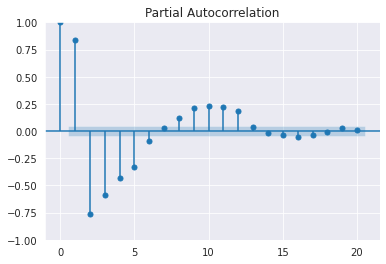

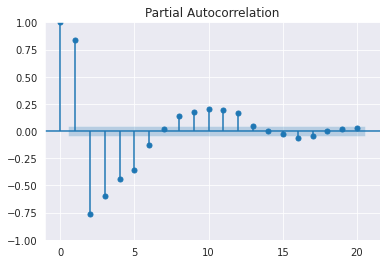

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train["TMAX"], method="ywm", lags=20)
plt.show()
plot_pacf(train["TMIN"], method="ywm", lags=20)
plt.show()

We are using 12 lags for both maximum and minimum temperatures.

In [15]:
from statsmodels.tsa.ar_model import AutoReg

tmax_model = AutoReg(train["TMAX"], lags=12)
tmin_model = AutoReg(train["TMIN"], lags=12)
tmax_model_fit = tmax_model.fit()
tmin_model_fit = tmin_model.fit()

The model has the following Mean Absolute Error on the Testing set.

In [16]:
ar_tmax_predictions = tmax_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
ar_tmin_predictions = tmin_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

tmax_mae = mean_absolute_error(y_test["TMAX"], ar_tmax_predictions)
tmin_mae = mean_absolute_error(y_test["TMIN"], ar_tmin_predictions)
print(f"Maximum Temperature Mean Absolute Error: {round(tmax_mae, 2)}")
print(f"Minimum Temperature Mean Absolute Error: {round(tmin_mae, 2)}")

Maximum Temperature Mean Absolute Error: 3.32
Minimum Temperature Mean Absolute Error: 3.4


Graphically it looks like:

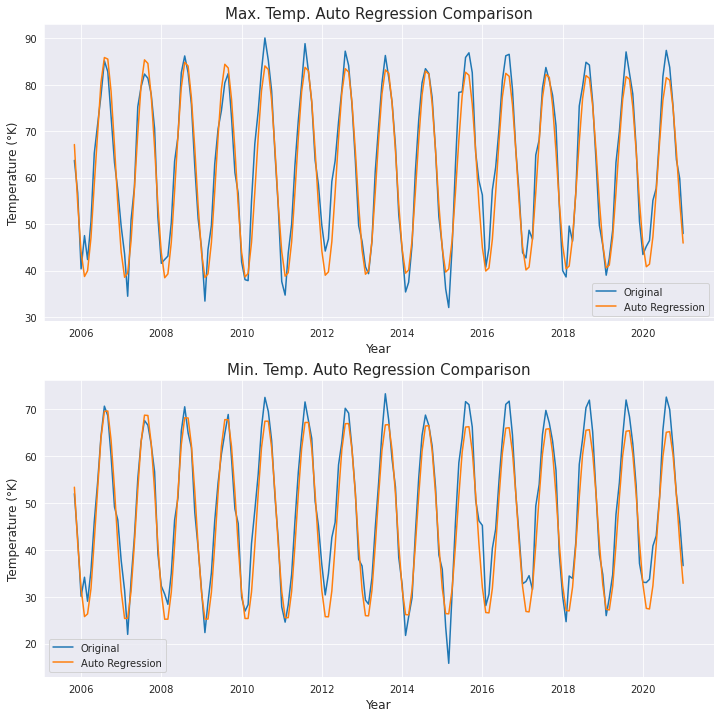

In [17]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))
sns.lineplot(x=y_test.index, y=y_test["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=y_test.index, y=ar_tmax_predictions.values,
			 label="Auto Regression", ax=axes[0])
axes[0].set_title("Max. Temp. Auto Regression Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=y_test.index, y=y_test["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=y_test.index, y=ar_tmin_predictions.values,
			 label="Auto Regression", ax=axes[1])
axes[1].set_title("Min. Temp. Auto Regression Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

### Auto Regression with Walk Forward
It consists of the same as the Auto Regression, but now we use the predicted values as part of
the training set used to predict the next one.

In [18]:
data = train["TMAX"].copy()
tmax_predictions = []
for t in test["TMAX"]:
	model = AutoReg(data, lags=12)
	model_fit = model.fit()
	y = model_fit.predict(start=len(data), end=len(train) + len(test) - 1)
	tmax_predictions.append(y.values[0])
	data = np.append(data, t)
	data = pd.Series(data)

data = train["TMIN"].copy()
tmin_predictions = []
for t in test["TMIN"]:
	model = AutoReg(data, lags=12)
	model_fit = model.fit()
	y = model_fit.predict(start=len(data), end=len(train) + len(test) - 1)
	tmin_predictions.append(y.values[0])
	data = np.append(data, t)
	data = pd.Series(data)

The model has the following Mean Absolute Error on the Testing set.

In [19]:
tmax_mae = mean_absolute_error(y_test["TMAX"], tmax_predictions)
tmin_mae = mean_absolute_error(y_test["TMIN"], tmin_predictions)
print(f"Maximum Temperature Mean Absolute Error: {round(tmax_mae, 2)}")
print(f"Minimum Temperature Mean Absolute Error: {round(tmin_mae, 2)}")

Maximum Temperature Mean Absolute Error: 2.85
Minimum Temperature Mean Absolute Error: 2.61


And the following graph:

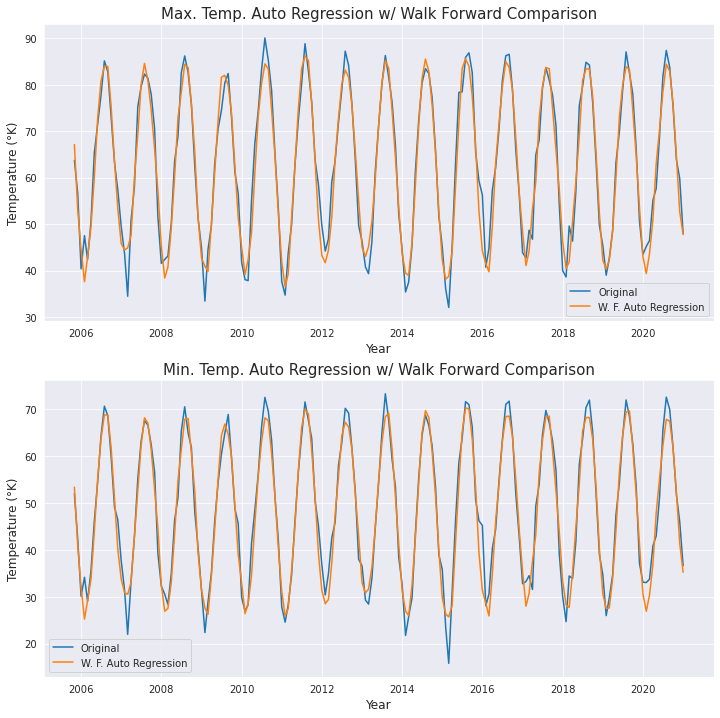

In [20]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))
sns.lineplot(x=y_test.index, y=y_test["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=y_test.index, y=tmax_predictions,
			 label="W. F. Auto Regression", ax=axes[0])
axes[0].set_title("Max. Temp. Auto Regression w/ Walk Forward Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=y_test.index, y=y_test["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=y_test.index, y=tmin_predictions,
			 label="W. F. Auto Regression", ax=axes[1])
axes[1].set_title("Min. Temp. Auto Regression w/ Walk Forward Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

### Moving Average Model
The same as the Auto Regression, but now instead of using the past values, we use the difference
(the residual) of a past past value with its immediate previous one.

First, plot the Autocorrelation graph to choose the right number of lags.

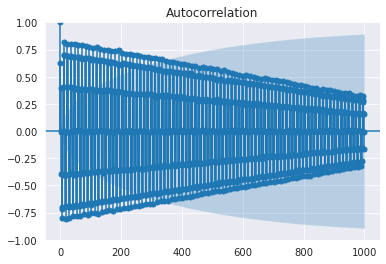

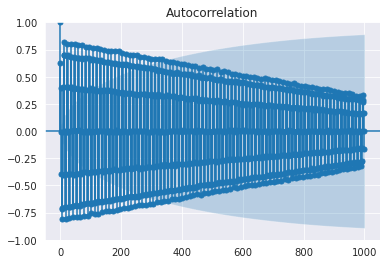

In [119]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train["tmax_diff1"], lags=1000)
plt.show()
plot_acf(train["tmin_diff1"], lags=1000)
plt.show()

We see that in both temperatures, the autocorrelation is going to zero.

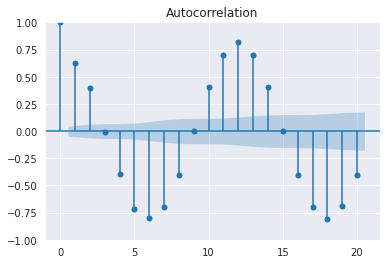

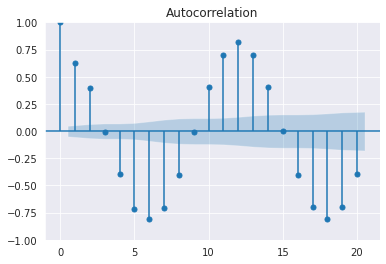

In [120]:
plot_acf(train["tmax_diff1"], lags=20)
plt.show()
plot_acf(train["tmin_diff1"], lags=20)
plt.show()

In [121]:
X_train, y_train = train[["tmax_diff1", "tmin_diff1"]], train[["TMAX", "TMIN"]]
X_test, y_test = test[["tmax_diff1", "tmin_diff1"]], test[["TMAX", "TMIN"]]

tmax_model = AutoReg(train["tmax_diff1"], lags=12)
tmin_model = AutoReg(train["tmin_diff1"], lags=12)
tmax_model_fit = tmax_model.fit()
tmin_model_fit = tmin_model.fit()

The model has the following Mean Absolute Error on the Testing set.

In [122]:
tmax_resid = tmax_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
tmin_resid = tmin_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

ma_tmax_predictions = test["tmax_lag1"] + tmax_resid
ma_tmin_predictions = test["tmin_lag1"] + tmin_resid
tmax_mae = mean_absolute_error(y_test["TMAX"], ma_tmax_predictions)
tmin_mae = mean_absolute_error(y_test["TMIN"], ma_tmin_predictions)
print(f"Maximum Temperature Mean Absolute Error: {round(tmax_mae, 2)}")
print(f"Minimum Temperature Mean Absolute Error: {round(tmin_mae, 2)}")

Maximum Temperature Mean Absolute Error: 3.45
Minimum Temperature Mean Absolute Error: 3.13


And the following graph.

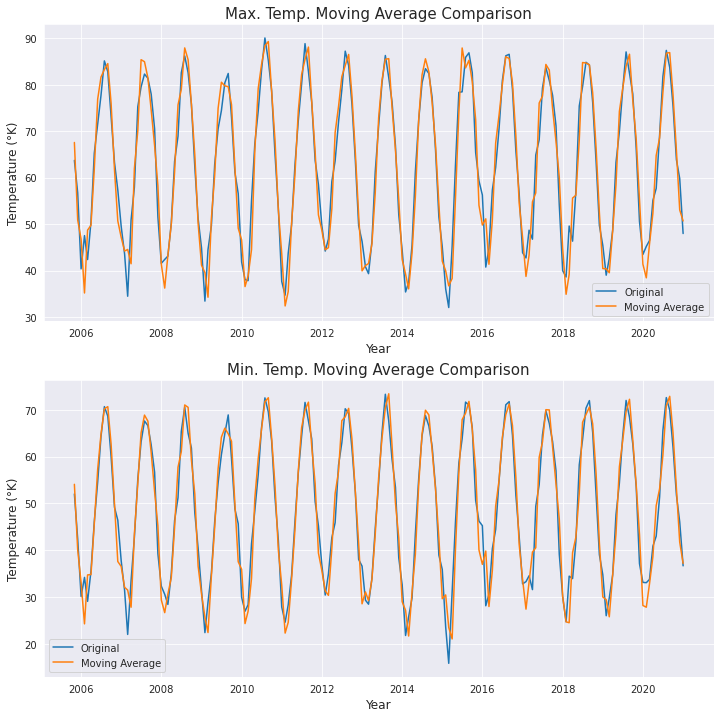

In [123]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))
sns.lineplot(x=y_test.index, y=y_test["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=y_test.index, y=ma_tmax_predictions,
			 label="Moving Average", ax=axes[0])
axes[0].set_title("Max. Temp. Moving Average Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=y_test.index, y=y_test["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=y_test.index, y=ma_tmin_predictions,
			 label="Moving Average", ax=axes[1])
axes[1].set_title("Min. Temp. Moving Average Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

### Moving Average with Walk Forward
Same as Moving Average Model, but we use the predicted values in the training set to the future
predictions.

In [26]:
data = train["tmax_diff1"].copy()
tmax_predictions = []
for i, t in enumerate(test["tmax_diff1"]):
	model = AutoReg(data, lags=12)
	model_fit = model.fit()
	pred_resid = model_fit.predict(start=len(data), end=len(train) + len(test) - 1)
	pred_resid = pd.Series(index=test.index[i:], data=pred_resid.values)
	y = test["tmax_lag1"][i:] + pred_resid
	tmax_predictions.append(y.values[0])
	data = np.append(data, t)
	data = pd.Series(data)

data = train["tmin_diff1"].copy()
tmin_predictions = []
for i, t in enumerate(test["tmin_diff1"]):
	model = AutoReg(data, lags=12)
	model_fit = model.fit()
	pred_resid = model_fit.predict(start=len(data), end=len(train) + len(test) - 1)
	pred_resid = pd.Series(index=test.index[i:], data=pred_resid.values)
	y = test["tmin_lag1"][i:] + pred_resid
	tmin_predictions.append(y.values[0])
	data = np.append(data, t)
	data = pd.Series(data)

The model has the following Mean Absolute Error on the Testing set.

In [27]:
tmax_mae = mean_absolute_error(y_test["TMAX"], tmax_predictions)
tmin_mae = mean_absolute_error(y_test["TMIN"], tmin_predictions)
print(f"Maximum Temperature Mean Absolute Error: {round(tmax_mae, 2)}")
print(f"Minimum Temperature Mean Absolute Error: {round(tmin_mae, 2)}")

Maximum Temperature Mean Absolute Error: 2.91
Minimum Temperature Mean Absolute Error: 2.6


And the following graph.

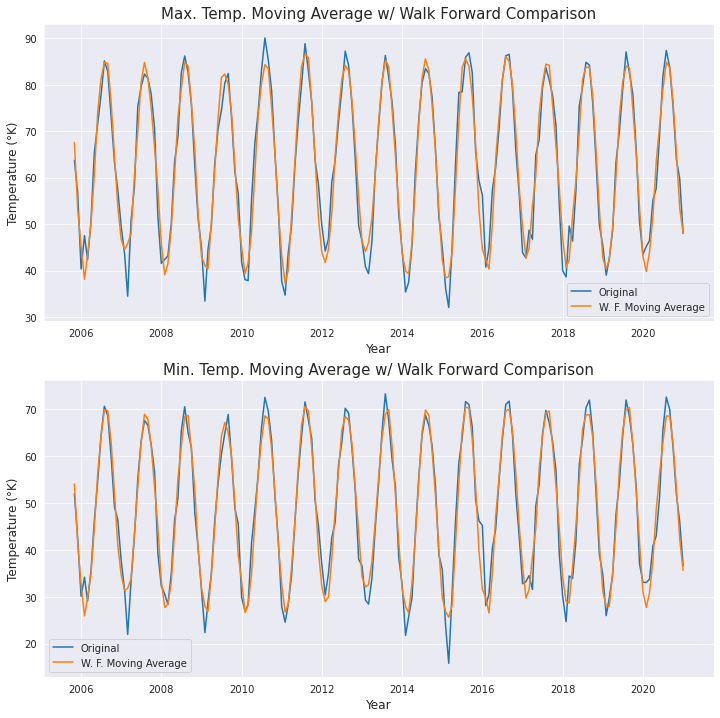

In [28]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))
sns.lineplot(x=y_test.index, y=y_test["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=y_test.index, y=tmax_predictions,
			 label="W. F. Moving Average", ax=axes[0])
axes[0].set_title("Max. Temp. Moving Average w/ Walk Forward Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=y_test.index, y=y_test["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=y_test.index, y=tmin_predictions,
			 label="W. F. Moving Average", ax=axes[1])
axes[1].set_title("Min. Temp. Moving Average w/ Walk Forward Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

### ARIMA Model
This model combines the Auto Regression (AR) with an Integrated (I) Moving Average (MA), that is,
 a combination of a number of differences already applied on the model in order to make it
 stationary.

It takes 3 parameters (p, d, q):
1. p: the Auto Regressive parameter
2. d: the number of times that the raw observations are differenced (the degree)
3. q: the Moving Average parameter.

We already know p and q. And for d, we are going to apply the Adfuller test.


In [29]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(temperatures):
	"""
	Augmented Dickey-Fuller test.
	https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
	"""
	result = adfuller(temperatures)
	labels = ["ADF Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"]
	for value, label in zip(result, labels):
		print(f"{label}: {value}")
	if result[1] <= 0.05:
		print("There is strong evidence against the null hypothesis (Ho). Reject the null "
		      "hypothesis")
	else:
		print("Weak evidence against null hypothesis.")

print("Adfuller test for Maximum Temperature:")
adfuller_test(train["TMAX"])
print("\n")
print("Adfuller test for Minimum Temperature:")
adfuller_test(train["TMIN"])

Adfuller test for Maximum Temperature:
ADF Test Statistic: -3.398792724070583
p-value: 0.011000096474294256
#Lags Used: 25
Number of Observations Used: 1614
There is strong evidence against the null hypothesis (Ho). Reject the null hypothesis


Adfuller test for Minimum Temperature:
ADF Test Statistic: -3.566656297638494
p-value: 0.006431432741451762
#Lags Used: 25
Number of Observations Used: 1614
There is strong evidence against the null hypothesis (Ho). Reject the null hypothesis


The test indicates that for both Maximum and Minimum Temperatures, the data is stationary.

In [30]:
from statsmodels.tsa.arima.model import ARIMA

tmax_model = ARIMA(train["TMAX"], order=(12, 0, 12))
tmin_model = ARIMA(train["TMIN"], order=(12, 0, 12))
tmax_model_fit = tmax_model.fit()
tmin_model_fit = tmin_model.fit()

/home/cris/miniconda3/envs/data/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cris/miniconda3/envs/data/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The model has the following Mean Absolute Error on the Testing set.

In [31]:
arima_tmax_predictions = tmax_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
arima_tmin_predictions = tmin_model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

tmax_mae = mean_absolute_error(y_test["TMAX"], arima_tmax_predictions)
tmin_mae = mean_absolute_error(y_test["TMIN"], arima_tmin_predictions)
print(f"Maximum Temperature Mean Absolute Error: {round(tmax_mae, 2)}")
print(f"Minimum Temperature Mean Absolute Error: {round(tmin_mae, 2)}")

Maximum Temperature Mean Absolute Error: 2.78
Minimum Temperature Mean Absolute Error: 2.7


Graphically we have:

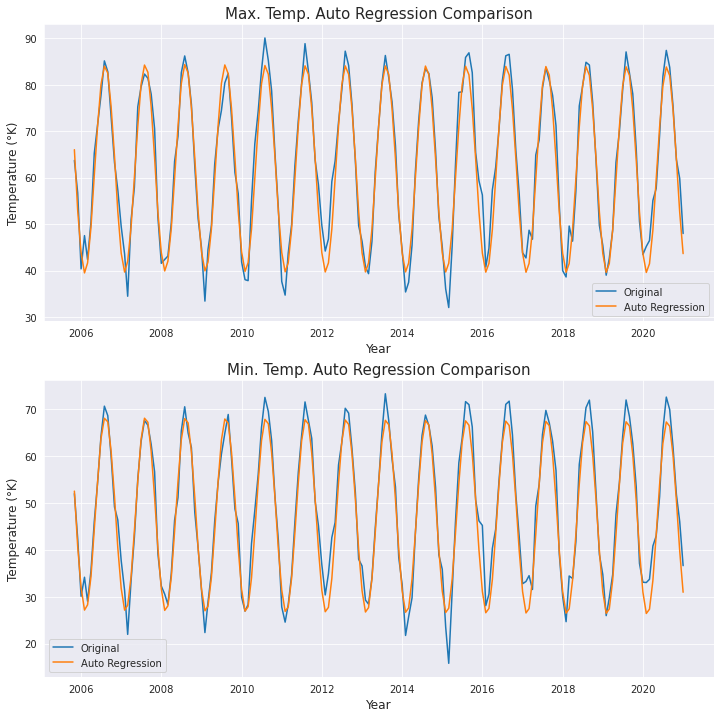

In [32]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))
sns.lineplot(x=y_test.index, y=y_test["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=y_test.index, y=arima_tmax_predictions.values,
			 label="Auto Regression", ax=axes[0])
axes[0].set_title("Max. Temp. Auto Regression Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=y_test.index, y=y_test["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=y_test.index, y=arima_tmin_predictions.values,
			 label="Auto Regression", ax=axes[1])
axes[1].set_title("Min. Temp. Auto Regression Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

## Yearly Analysis
As we have predicted the monthly temperature, now we can average by year each temperature to get
predictions for a yearly schema.

Let's compare the three models described above.

In [33]:
test_yearly = test.groupby(pd.Grouper(freq="Y")).mean()

ar_tmax_yearly_prediction = ar_tmax_predictions.groupby(pd.Grouper(freq="Y")).mean()
ma_tmax_yearly_prediction = ma_tmax_predictions.groupby(pd.Grouper(freq="Y")).mean()
arima_tmax_yearly_prediction = arima_tmax_predictions.groupby(pd.Grouper(freq="Y")).mean()

ar_tmin_yearly_prediction = ar_tmin_predictions.groupby(pd.Grouper(freq="Y")).mean()
ma_tmin_yearly_prediction = ma_tmin_predictions.groupby(pd.Grouper(freq="Y")).mean()
arima_tmin_yearly_prediction = arima_tmin_predictions.groupby(pd.Grouper(freq="Y")).mean()

We have the following Mean Absolute Errors.

In [34]:
ar_tmax_yearly_mae = mean_absolute_error(test_yearly["TMAX"], ar_tmax_yearly_prediction)
ma_tmax_yearly_mae = mean_absolute_error(test_yearly["TMAX"], ma_tmax_yearly_prediction)
arima_tmax_yearly_mae = mean_absolute_error(test_yearly["TMAX"], arima_tmax_yearly_prediction)
ar_tmin_yearly_mae = mean_absolute_error(test_yearly["TMIN"], ar_tmin_yearly_prediction)
ma_tmin_yearly_mae = mean_absolute_error(test_yearly["TMIN"], ma_tmin_yearly_prediction)
arima_tmin_yearly_mae = mean_absolute_error(test_yearly["TMIN"], arima_tmin_yearly_prediction)

print(f"AR Yearly Max. Temp. Mean Absolute Error: {round(ar_tmax_yearly_mae, 2)}")
print(f"MA Yearly Max. Temp. Mean Absolute Error: {round(ma_tmax_yearly_mae, 2)}")
print(f"ARIMA Yearly Max. Temp. Mean Absolute Error: {round(arima_tmax_yearly_mae, 2)}")
print("\n")
print(f"AR Yearly Min. Temp. Mean Absolute Error: {round(ar_tmin_yearly_mae, 2)}")
print(f"MA Yearly Min. Temp. Mean Absolute Error: {round(ma_tmin_yearly_mae, 2)}")
print(f"ARIMA Yearly Min. Temp. Mean Absolute Error: {round(arima_tmin_yearly_mae, 2)}")

AR Yearly Max. Temp. Mean Absolute Error: 1.75
MA Yearly Max. Temp. Mean Absolute Error: 0.54
ARIMA Yearly Max. Temp. Mean Absolute Error: 1.35


AR Yearly Min. Temp. Mean Absolute Error: 2.26
MA Yearly Min. Temp. Mean Absolute Error: 0.42
ARIMA Yearly Min. Temp. Mean Absolute Error: 1.62


And graphically:

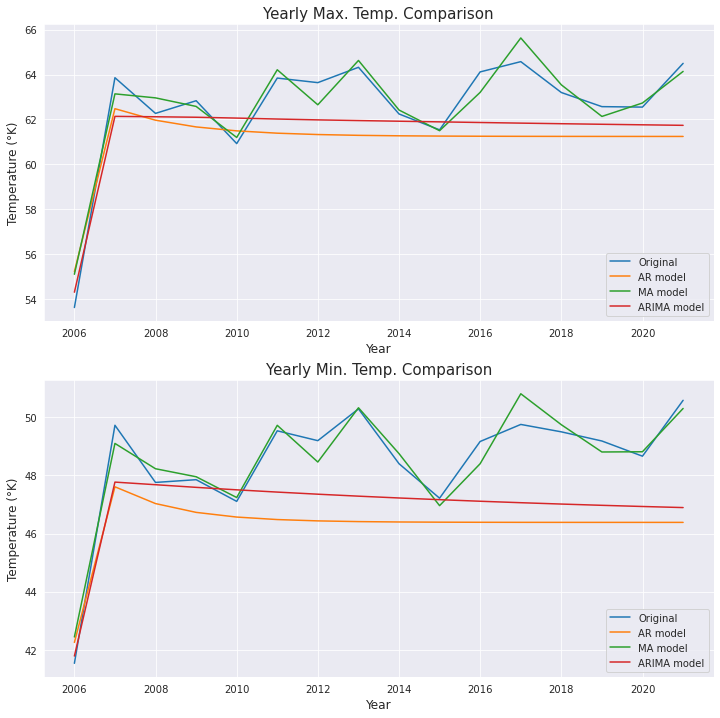

In [35]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))

sns.lineplot(x=test_yearly.index, y=test_yearly["TMAX"].values, label="Original", ax=axes[0])
sns.lineplot(x=test_yearly.index, y=ar_tmax_yearly_prediction,
			 label="AR model", ax=axes[0])
sns.lineplot(x=test_yearly.index, y=ma_tmax_yearly_prediction,
			 label="MA model", ax=axes[0])
sns.lineplot(x=test_yearly.index, y=arima_tmax_yearly_prediction,
			 label="ARIMA model", ax=axes[0])
axes[0].set_title("Yearly Max. Temp. Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=test_yearly.index, y=test_yearly["TMIN"].values, label="Original", ax=axes[1])
sns.lineplot(x=test_yearly.index, y=ar_tmin_yearly_prediction,
			 label="AR model", ax=axes[1])
sns.lineplot(x=test_yearly.index, y=ma_tmin_yearly_prediction,
			 label="MA model", ax=axes[1])
sns.lineplot(x=test_yearly.index, y=arima_tmin_yearly_prediction,
			 label="ARIMA model", ax=axes[1])
axes[1].set_title("Yearly Min. Temp. Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()

Let's analyze the entire dataset.

In [283]:
ma_tmax = AutoReg(monthly_df["tmax_diff1"], lags=12)
ma_tmin = AutoReg(monthly_df["tmin_diff1"], lags=12)

In [284]:
ma_tmax_fit = ma_tmax.fit()
ma_tmin_fit = ma_tmin.fit()

For the entire dataset, we have the following errors:

In [287]:
tmax_resid = ma_tmax_fit.predict().dropna()
tmin_resid = ma_tmin_fit.predict().dropna()

ma_tmax_predictions = monthly_df["tmax_lag1"].iloc[12:] + tmax_resid
ma_tmin_predictions = monthly_df["tmin_lag1"].iloc[12:] + tmin_resid
tmax_mae = mean_absolute_error(monthly_df["TMAX"].iloc[12:], ma_tmax_predictions)
tmin_mae = mean_absolute_error(monthly_df["TMIN"].iloc[12:], ma_tmin_predictions)
print(f"Maximum Temperature Mean Absolute Error: {round(tmax_mae, 2)}")
print(f"Minimum Temperature Mean Absolute Error: {round(tmin_mae, 2)}")

Maximum Temperature Mean Absolute Error: 2.77
Minimum Temperature Mean Absolute Error: 2.47


In [288]:
yearly_df = monthly_df.iloc[12:].groupby(pd.Grouper(freq="Y")).mean()
ma_tmax_yearly_prediction = ma_tmax_predictions.groupby(pd.Grouper(freq="Y")).mean()
ma_tmin_yearly_prediction = ma_tmin_predictions.groupby(pd.Grouper(freq="Y")).mean()

And the predictions looks like:

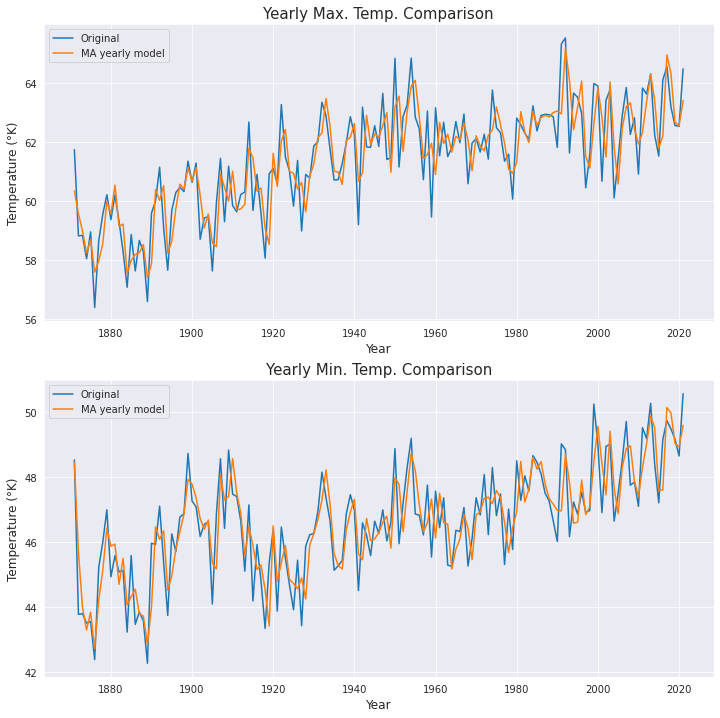

In [289]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 12))

sns.lineplot(x=yearly_df.index, y=yearly_df["TMAX"].values, label="Original",
             ax=axes[0])
sns.lineplot(x=yearly_df.index, y=ma_tmax_yearly_prediction,
			 label="MA yearly model", ax=axes[0])
axes[0].set_title("Yearly Max. Temp. Comparison", fontsize=15)
axes[0].set_ylabel("Temperature (°K)", fontsize=12)
axes[0].set_xlabel("Year", fontsize=12)
sns.lineplot(x=yearly_df.index, y=yearly_df["TMIN"].values, label="Original",
             ax=axes[1])
sns.lineplot(x=yearly_df.index, y=ma_tmin_yearly_prediction,
			 label="MA yearly model", ax=axes[1])
axes[1].set_title("Yearly Min. Temp. Comparison", fontsize=15)
axes[1].set_ylabel("Temperature (°K)", fontsize=12)
axes[1].set_xlabel("Year", fontsize=12)
plt.show()